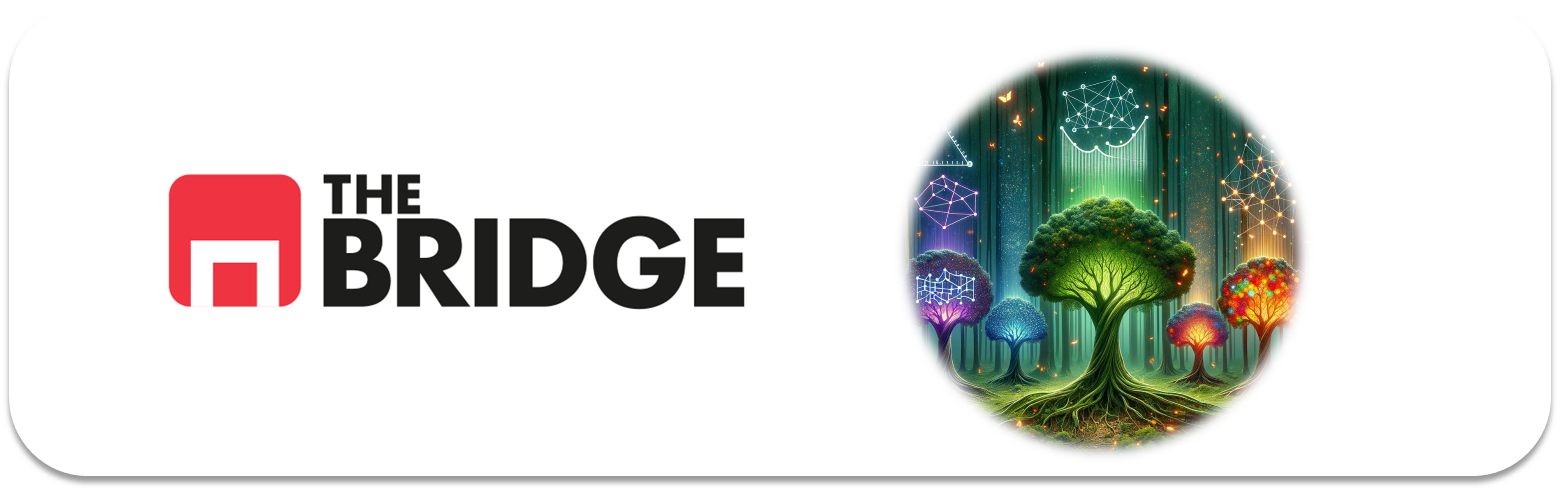

# PRACTICA OBLIGATORIA
## **Ensembles: Bagging y Boosting**

* La práctica obligatoria de esta unidad consiste en un único ejercicio de obtención del mejor modelo para la resolución de un problema de clasificación sobre diabetes en la india. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


pd.options.mode.copy_on_write = True

/tmp/ipykernel_18437/1672863456.py:8: Pandas4Warning: The 'mode.copy_on_write' option is deprecated. Copy-on-Write can no longer be disabled (it is always enabled with pandas >= 3.0), and setting the option has no impact. This option will be removed in pandas 4.0.
  pd.options.mode.copy_on_write = True


### Descripción del dataset

El dataset de los **Pima Indians Diabetes** contiene datos de un grupo de mujeres de al menos 21 años de edad de ascendencia india Pima que viven cerca de Phoenix, Arizona, EE. UU. Las características del dataset incluyen varios predictores médicos y un objetivo que indica si la paciente desarrolló diabetes dentro de cinco años.

#### Características del Dataset

> Las variables incluidas en el dataset son:
>
>1. **Número de Embarazos**: Cantidad de veces embarazada.
>2. **Concentración de Glucosa en Plasma**: Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.
>3. **Presión Arterial Diastólica**: Presión arterial diastólica (mm Hg).
>4. **Grosor del Pliegue Cutáneo del Tríceps**: Grosor del pliegue cutáneo del tríceps (mm).
>5. **Insulina en Suero**: Insulina en suero a 2 horas (mu U/ml).
>6. **Índice de Masa Corporal**: Peso en kg/(altura en m)².
>7. **Función del Pedigree de Diabetes**: Una función que representa la predisposición genética a la diabetes.
>8. **Edad**: Edad en años.
>9. **Variable Objetivo**: Indica si la paciente desarrolló diabetes (1) o no (0).

### Carga de datos

El dataset lo puedes encontrar en la siguiente *url* y a continuación se proporciona una lista de nombres sugeridos para las columnas:

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ["preg", "plas", "pres", "skin", "test", "mass", "pedi", "age", "class"]

df_pid = pd.read_csv(url, names=names)
df_pid.head()

,preg,plas,pres,skin,test,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df_pid.info()

<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Enunciado

Construye el mejor modelo que puedas para predecir a partir de los datos de entrada si una mujer de la tribu Pima desarrollará diabetes. Para ello obtén al menos tres modelos a partir de tecnologías de bagging y boosting (al menos uno de cada), compáralos sin utilizar el test y selecciona uno de ellos como el mejor (justificándolo). Termina el ejercicio probando el modelo seleccionado y con sus hiperparámetros optimizados contra un dataset de test que deberás haber reservado con anterioridad.

In [4]:
def get_quality(dataframe: pd.DataFrame):
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])
	return data.T

Nuestro dataset cuenta con 768 registros y 9 columnas.

In [5]:
print(f"El dataset cuenta con {df_pid.shape[0]} registros.")
print(f"El dataset cuenta con {df_pid.shape[1]} columnas.")
print("="*40)
df_pid.info()

El dataset cuenta con 768 registros.
El dataset cuenta con 9 columnas.
<class 'pandas.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   test    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Verificamos los duplicados

In [6]:
is_duplicated = df_pid.duplicated()
df_pid[is_duplicated]

,preg,plas,pres,skin,test,mass,pedi,age,class


Verificamos la calidad de nuestras columnas

In [7]:
get_quality(df_pid)

,Cardinality,Uniqueness,Null
preg,17.0,0.022135,0.0
plas,136.0,0.177083,0.0
pres,47.0,0.061198,0.0
skin,51.0,0.066406,0.0
test,186.0,0.242188,0.0
mass,248.0,0.322917,0.0
pedi,517.0,0.673177,0.0
age,52.0,0.067708,0.0
class,2.0,0.002604,0.0


No tenemos variables categóricas salvo nuestra variable objetivo `class`. La variable `preg` y `age` son numéricas discretas. Las restantes, son numericas continuas.

Nos adentramos en los estadísticos de nuestras variables...

In [8]:
df_pid.describe()

,preg,plas,pres,skin,test,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Hay dos variables (`test` y `pedi`) que tienen una notoria presencia de outliers y nos delatan distribuciones con una larga cola. También, llama la atención encontrarnos con un registro correspondiente a una persona que atraveso 17 embarazos.

### Análisis de features

#### `PREG`: **Número de Embarazos**

Cantidad de veces embarazada.

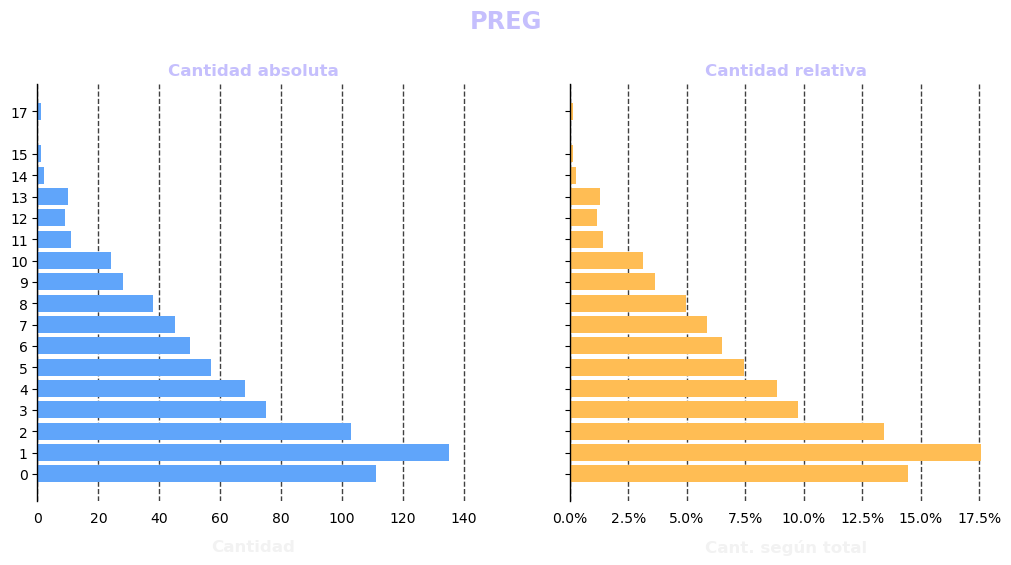

In [9]:
from matplotlib import ticker


serie = df_pid["preg"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `AGE`: Edad

Edad en años.

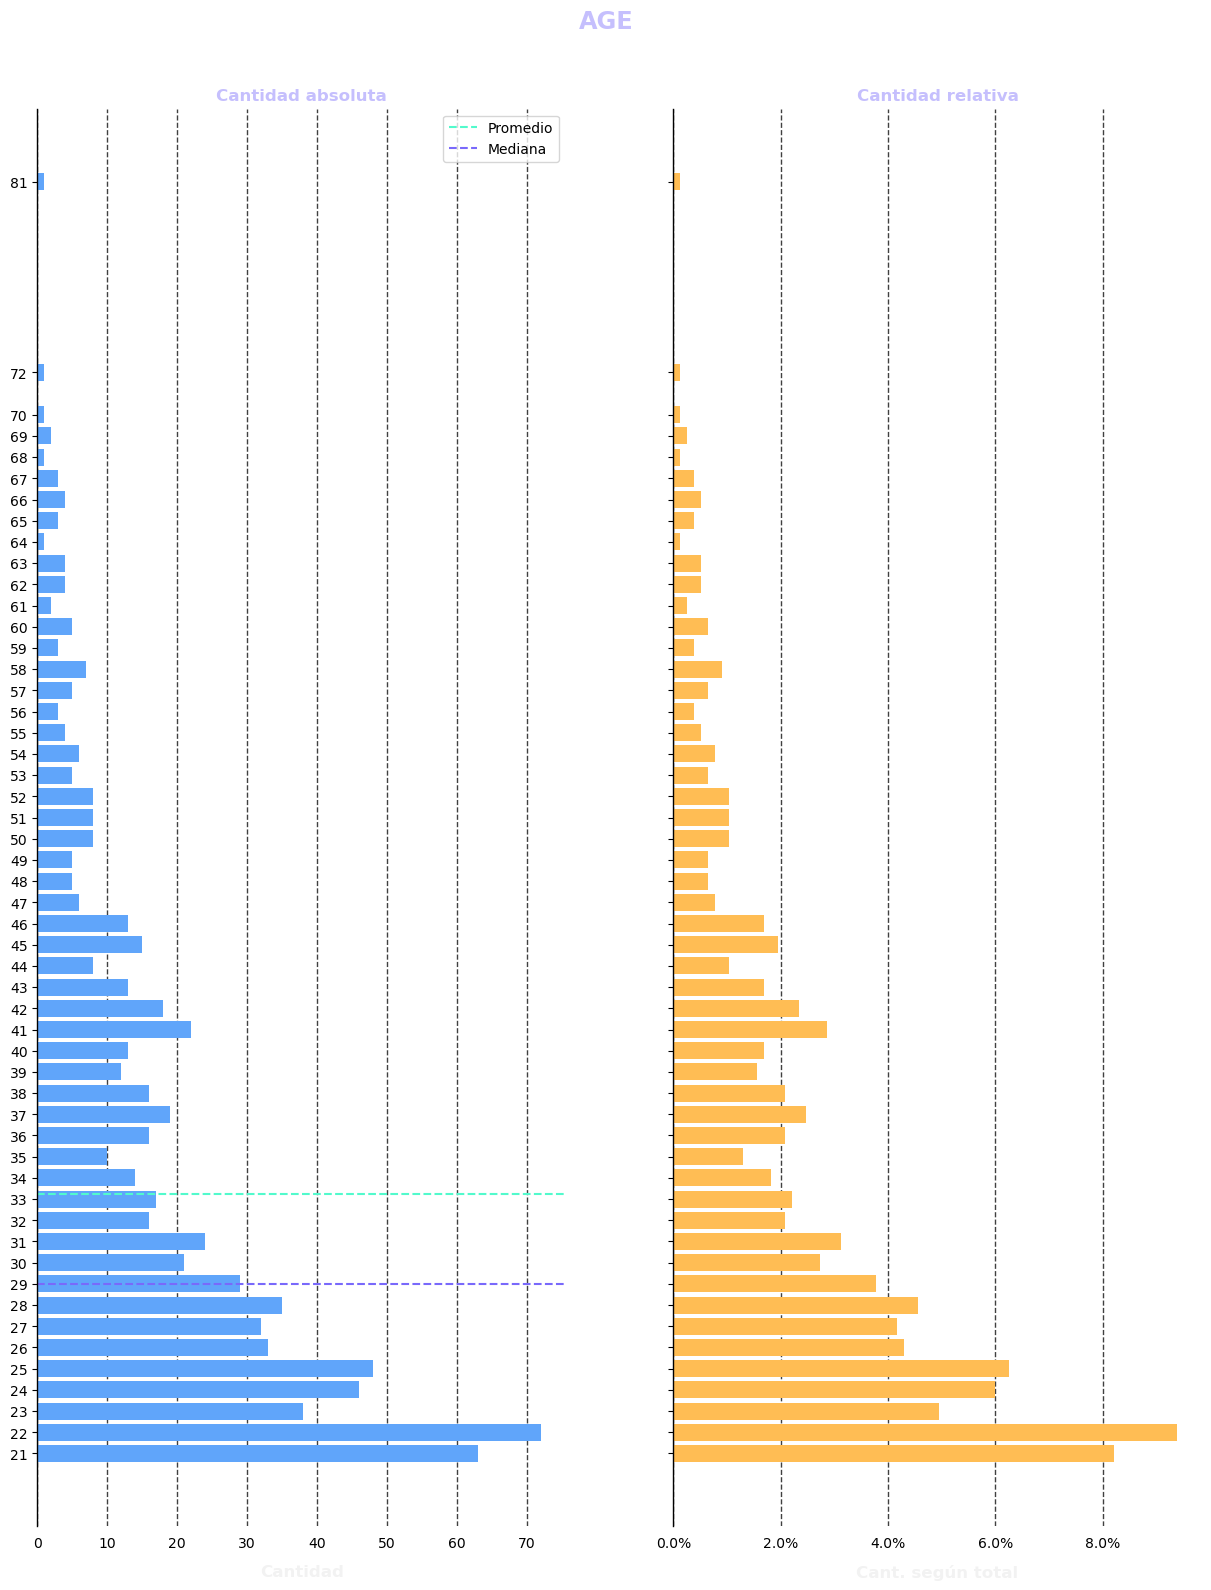

In [10]:
serie = df_pid["age"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(12, 15),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.05)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

axs[0].axhline(serie.mean(),
			   linestyle="dashed",
			   color="#52FACC",
			   label="Promedio")
axs[0].axhline(serie.median(),
			   linestyle="dashed",
			   color="#7969FB",
			   label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)
axs[0].legend()




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `CLASS`: **Target**

Indica si la paciente desarrolló diabetes (1) o no (0).

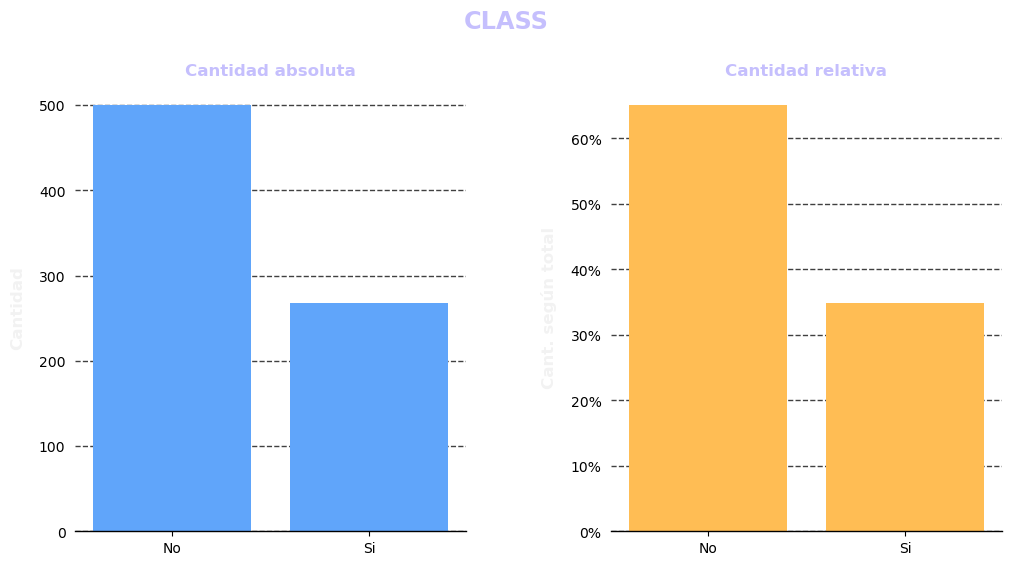

In [11]:
serie = df_pid["class"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].bar(x=data.index,
		   height=data.values,
		   data=data,
		   color="#60A5FA",
		   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="y", width=0)
axs[0].set_xticks(ticks=data.index, labels=["No", "Si"])
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_ylabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="y",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["left", "top", "right"]].set_visible(False)
axs[0].spines["bottom"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].bar(x=data.index,
		   height=data.values,
		   data=data,
		   color="#FFBD54",
		   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_xticks(ticks=data.index, labels=["No", "Si"])
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_ylabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="y", width=0)
axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="y",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["left", "top", "right"]].set_visible(False)
axs[1].spines["bottom"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

No es una clase que se encuentre muy desbalanceada.

#### `PLAS`: **Concentración de Glucosa en Plasma**

Concentración de glucosa en plasma a 2 horas en una prueba de tolerancia oral a la glucosa.

In [12]:
def filter_outliers(serie: pd.Series,
					whisker: float | None=1.75,
					below_zero=False):
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	filtered = serie[mask]
	return filtered

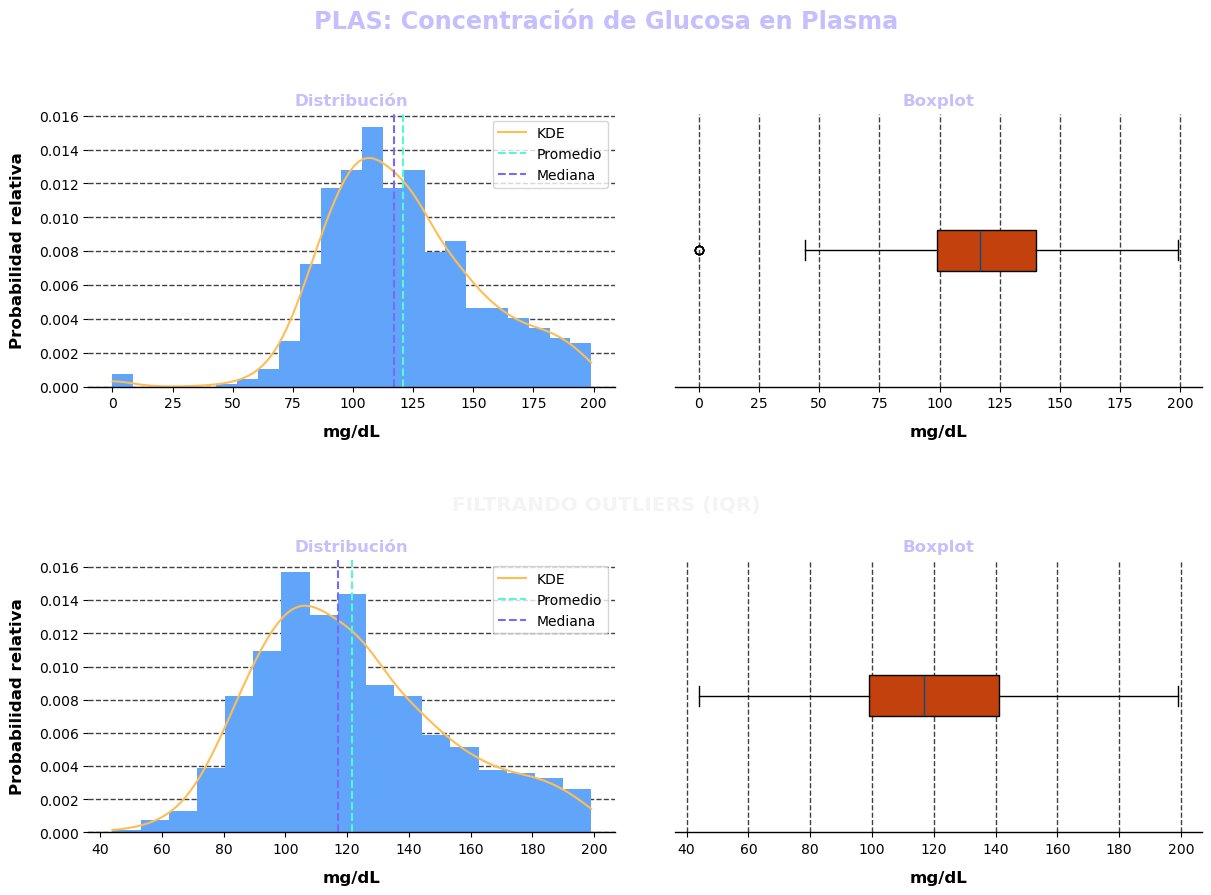

In [13]:
serie = df_pid["plas"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Concentración de Glucosa en Plasma",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("mg/dL", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("mg/dL", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("mg/dL", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("mg/dL", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

En un primer vistazo de los datos, podemos observar que los datos se encuentran truncado en un valor aproximado a 200 mg/dL. Es puede deberse a la alta correlación que tiene la variable con el target.

Buscando información en internet sobre el significado de las variables encontramos la siguiente info extraída de chatgpt:

**Contexto de medición**:

1. El paciente ingiere 75 g de glucosa.
2. Se mide la glucosa en plasma exactamente a las 2 horas.
3. Evalúa cómo el organismo procesa el azúcar.

Interpretación común (a las 2 horas):
- **Normal**: < 140 mg/dL
- **Prediabetes**: 140 – 199 mg/dL
- **Diabetes**: ≥ 200 mg/dL

#### `PRES`: **Presión Arterial Diastólica**

Presión arterial diastólica medida en *milímetros de mercurio (mm Hg)*.

Valores habituales de la presión arterial diastólica:
- **Normal**: 60–80 mm Hg
- **Alta**: ≥ 90 mm Hg
- **Baja**: < 60 mm Hg

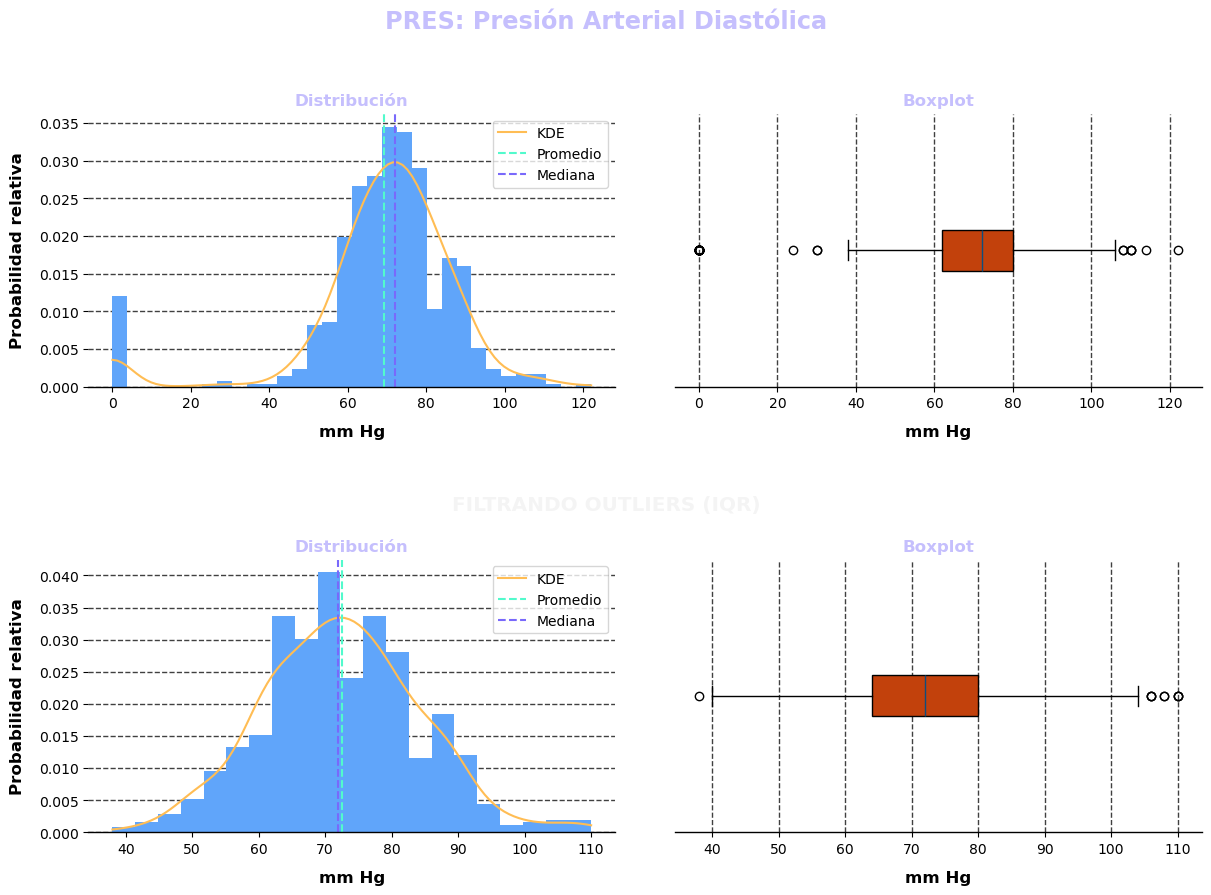

In [14]:
serie = df_pid["pres"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Presión Arterial Diastólica",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("mm Hg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("mm Hg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("mm Hg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("mm Hg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

#### `SKIN`: **Grosor del Pliegue Cutáneo del Tríceps**

Grosor del pliegue cutáneo del tríceps (mm).

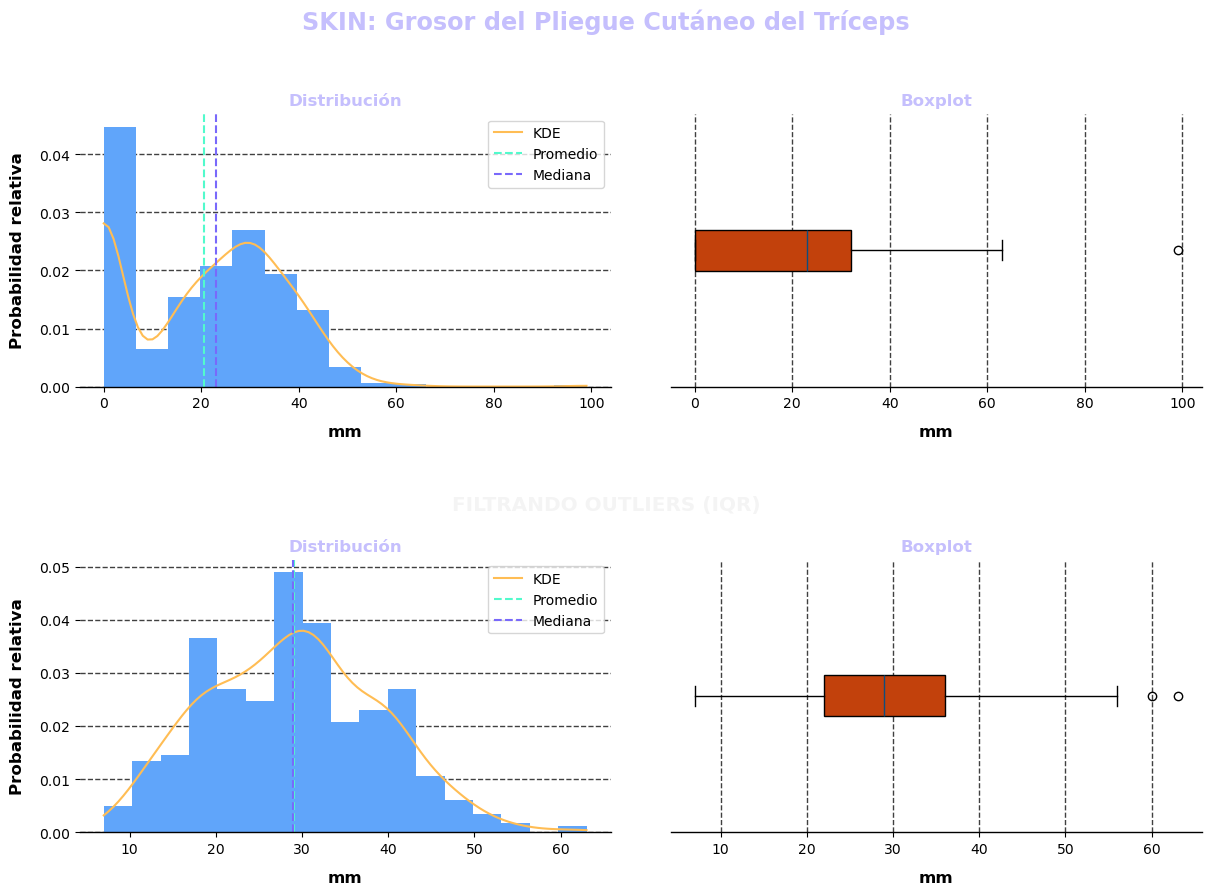

In [15]:
serie = df_pid["skin"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Grosor del Pliegue Cutáneo del Tríceps",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("mm", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("mm", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("mm", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("mm", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

#### `TEST`: **Insulina en Suero**

Insulina en suero a 2 horas medida en *micro-unidades por mililitro (mu U/ml | µU/mL)*.

> Corresponde a la concentración de insulina en el suero sanguíneo, medida 2 horas después de la ingesta de glucosa durante una prueba de tolerancia oral a la glucosa

Valores de referencia aproximados:
- **Normal**: 16 – 166 µU/mL
- **Valores muy bajos**: posible déficit de producción.
- **Valores altos**: posible resistencia a la insulina.

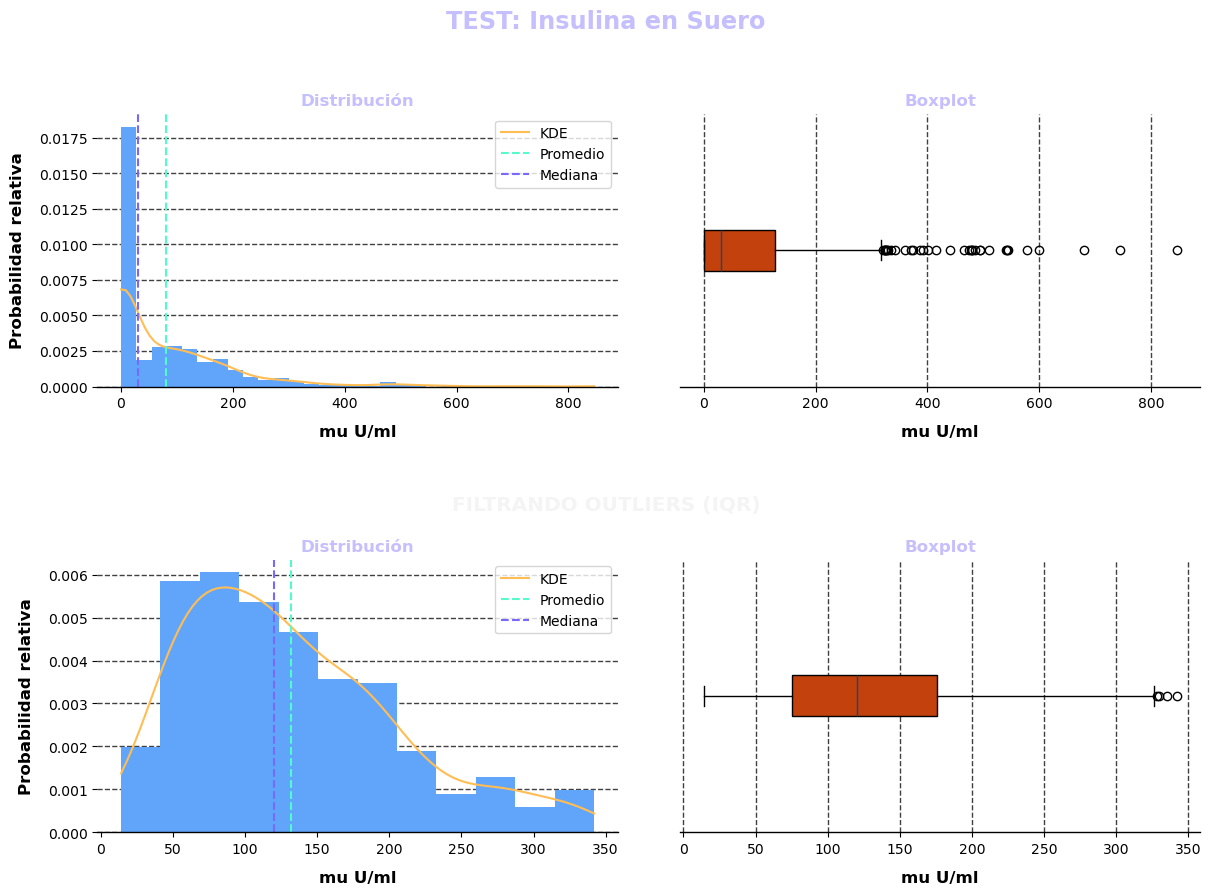

In [16]:
serie = df_pid["test"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Insulina en Suero",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("mu U/ml", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("mu U/ml", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("mu U/ml", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("mu U/ml", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

#### `MASS`: **Índice de Masa Corporal**

Peso en kg/(altura en m)².

Valores de referencia aproximados:
- **Bajo peso**: < 18.5 kg/m²
- **Normal**: 18.5 – 24.9 kg/m²
- **Sobrepeso**: 25.0 – 29.9 kg/m²
- **Obesidad**: ≥ 30.0 kg/m²

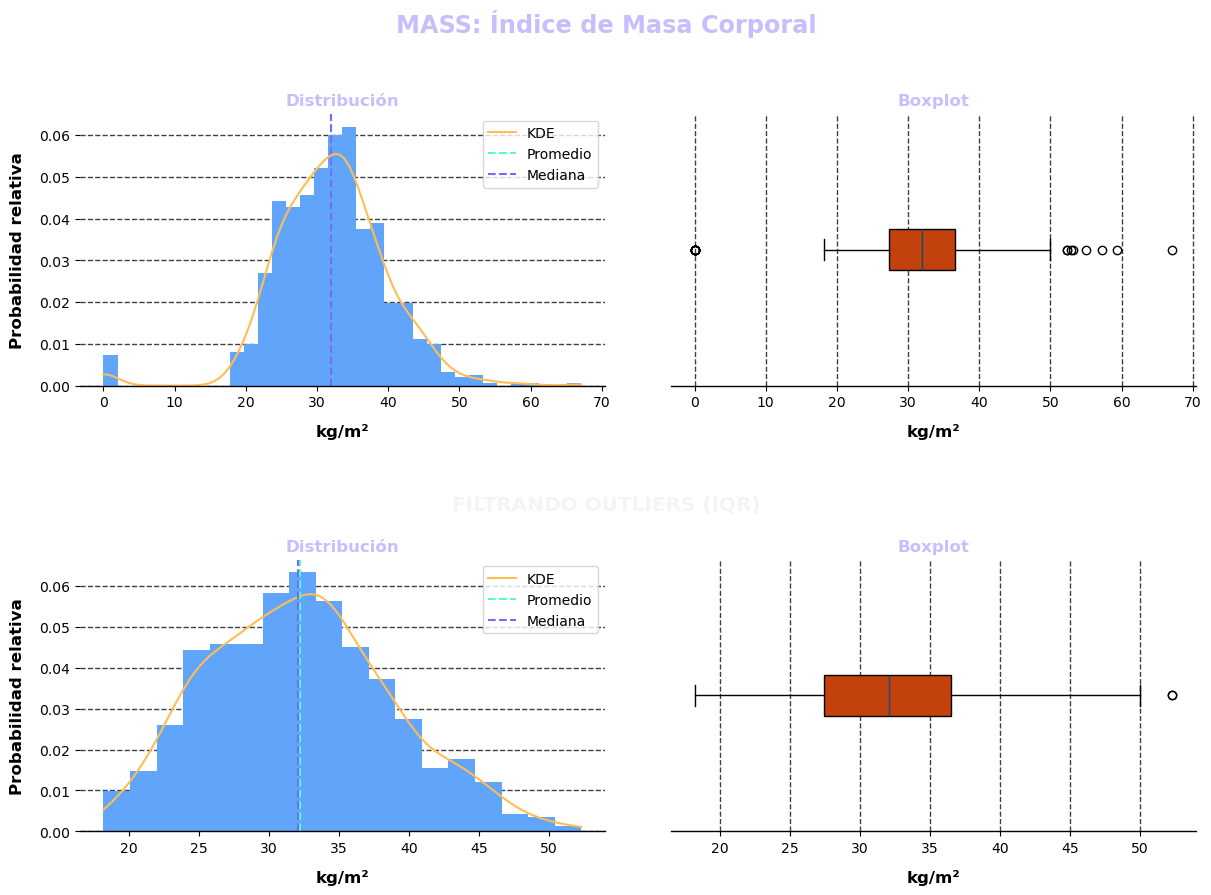

In [17]:
serie = df_pid["mass"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Índice de Masa Corporal",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg/m²", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg/m²", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg/m²", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg/m²", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

Llama la atención los valores cero en el índice de masa corporal. Entendemos que estos pueden haber sido valores nulos y se han completado con el número cero.

#### `PEDI`: **Función del Pedigree de Diabetes**

Una función que representa la predisposición genética a la diabetes.

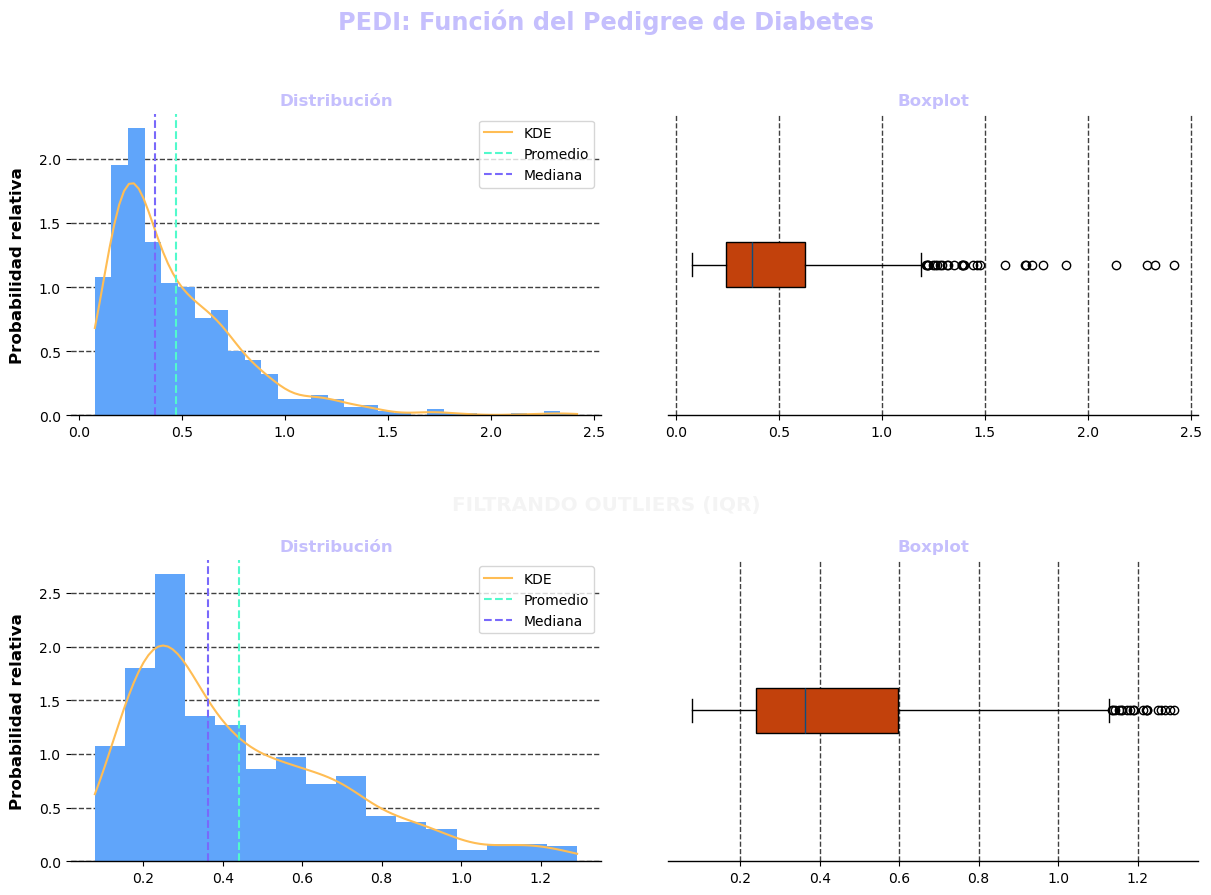

In [18]:
serie = df_pid["pedi"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Función del Pedigree de Diabetes",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

### Transformaciones

Podríamos categorizar algunos de nuestros datos numéricos para obtener una mejor comprensión del dataset, independientemente si después las utilizamos en el modelo o no.

#### `AGE`

In [19]:
def categorize_age(value):
	if value < 0:
		return "Desconocido"
	elif value < 5:
		return "Infancia temprana"
	elif value < 15:
		return "Niñez"
	elif value < 25:
		return "Adolescencia y juventud"
	elif value < 45:
		return "Adulto joven"
	elif value < 60:
		return "Adulto medio"
	else:
		return "Adulto mayor"

df_pid["age_category"] = df_pid["age"].apply(categorize_age)

#### `PLAS`

In [20]:
def categorize_plas(value):
	if value < 140:
		return "Normal"
	elif value < 199:
		return "Prediabetes"
	else:
		return "Diabetes"

df_pid["plas_category"] = df_pid["plas"].apply(categorize_plas)

#### `PRES`

In [21]:
def categorize_pres(value):
	if value < 60:
		return "Baja"
	elif value < 80:
		return "Normal"
	else:
		return "Alta"

df_pid["pres_category"] = df_pid["pres"].apply(categorize_pres)

#### `MASS`

- **Bajo peso**: < 18.5 kg/m²
- **Normal**: 18.5 – 24.9 kg/m²
- **Sobrepeso**: 25.0 – 29.9 kg/m²
- **Obesidad**: ≥ 30.0 kg/m²

In [22]:
def categorize_mass(value):
	if value < 18.5:
		return "Bajo"
	elif value < 24.9:
		return "Normal"
	elif value < 29.9:
		return "Sobrepeso"
	else:
		return "Obesidad"

df_pid["mass_category"] = df_pid["mass"].apply(categorize_mass)

### Train-Test Split

Realizamos un `train_test_split` en nuestros dataset, dejando un 20% de los mismos para test.

In [23]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
	df_pid,
	test_size=.2,
	stratify=df_pid["class"],
	random_state=99
)

Reseteamos los índices en los datasets.

In [24]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

#### Mini-EDA

In [25]:
import seaborn as sns

sns.set_style("whitegrid")

##### Análisis de `PREG`

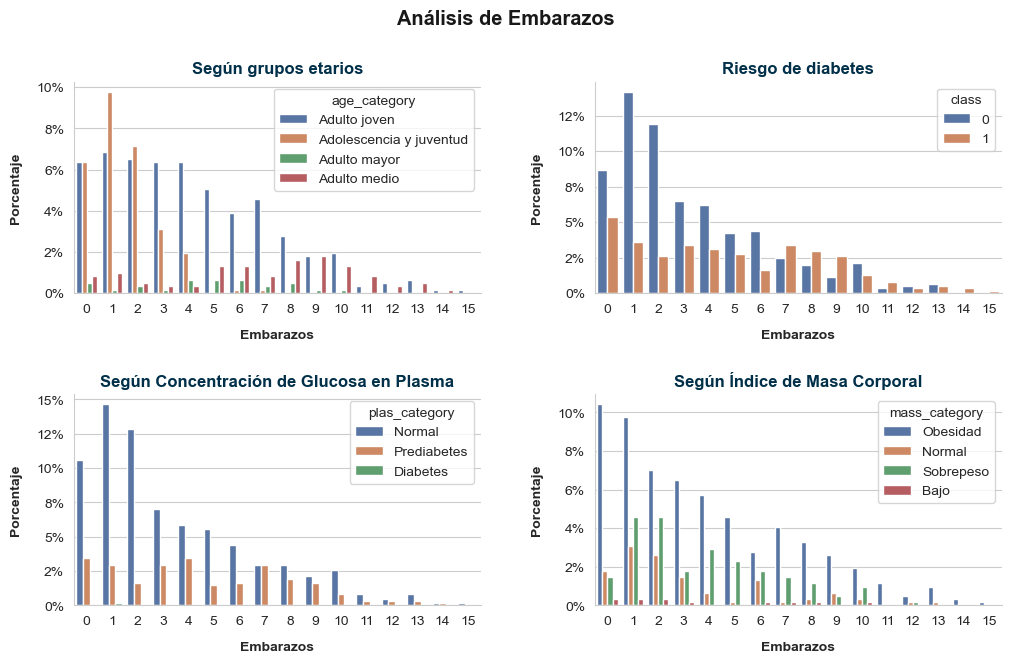

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Análisis de Embarazos",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Según grupos etarios",
					color="#003049",
					fontdict=font_config)
sns.countplot(data=df_train[["preg", "age_category"]],
			  x="preg",
			  hue="age_category",
			  stat="percent",
			  palette="deep",
			  ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("Embarazos", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Porcentaje", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Riesgo de diabetes",
					color="#003049",
					fontdict=font_config)
sns.countplot(data=df_train[["preg", "class"]],
			  x="preg",
			  hue="class",
			  stat="percent",
			  palette="deep",
			  ax=axs[0][1])
sns.despine(ax=axs[0][1])
axs[0][1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("Embarazos", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("Porcentaje", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Según Concentración de Glucosa en Plasma",
					color="#003049",
					fontdict=font_config)
sns.countplot(data=df_train[["preg", "plas_category"]],
			  x="preg",
			  hue="plas_category",
			  stat="percent",
			  palette="deep",
			  ax=axs[1][0])
sns.despine(ax=axs[1][0])
axs[1][0].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("Embarazos", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Porcentaje", labelpad=10, fontdict=font_config)





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Según Índice de Masa Corporal",
					color="#003049",
					fontdict=font_config)
sns.countplot(data=df_train[["preg", "mass_category"]],
			  x="preg",
			  hue="mass_category",
			  stat="percent",
			  palette="deep",
			  ax=axs[1][1])
sns.despine(ax=axs[1][1])
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("Embarazos", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Porcentaje", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

##### Análisis de `PLAS`

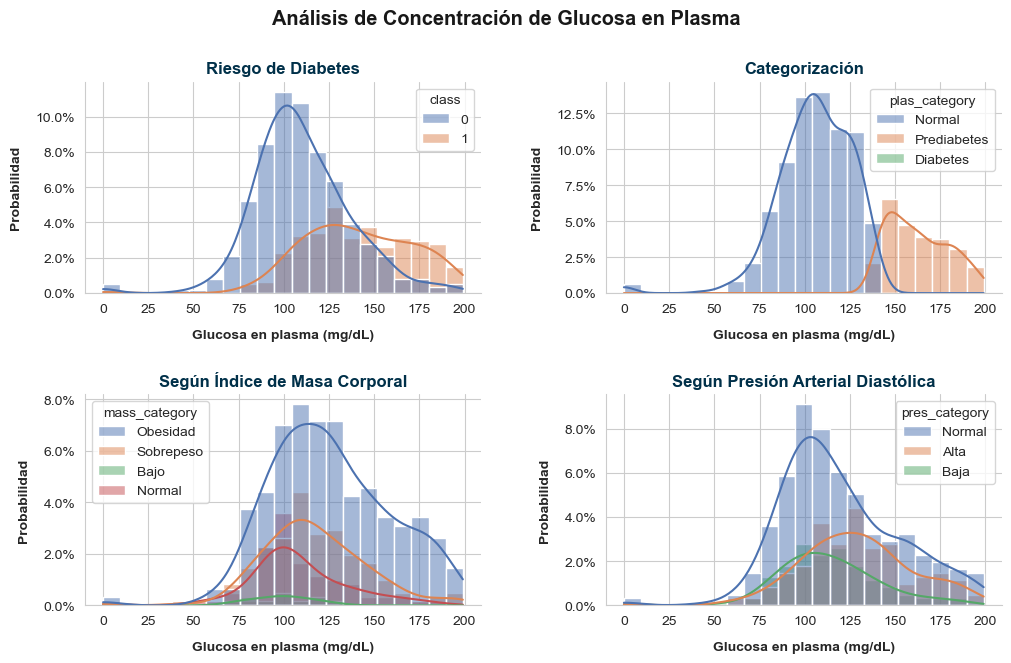

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Análisis de Concentración de Glucosa en Plasma",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Riesgo de Diabetes",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["class", "plas"]],
			 x="plas",
			 hue="class",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("Glucosa en plasma (mg/dL)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Categorización",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["plas_category", "plas"]],
			 x="plas",
			 hue="plas_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][1])
sns.despine(ax=axs[0][1])
axs[0][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("Glucosa en plasma (mg/dL)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Según Índice de Masa Corporal",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["mass_category", "plas"]],
			 x="plas",
			 hue="mass_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][0])
sns.despine(ax=axs[1][0])
axs[1][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("Glucosa en plasma (mg/dL)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Según Presión Arterial Diastólica",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["pres_category", "plas"]],
			 x="plas",
			 hue="pres_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][1])
sns.despine(ax=axs[1][1])
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("Glucosa en plasma (mg/dL)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

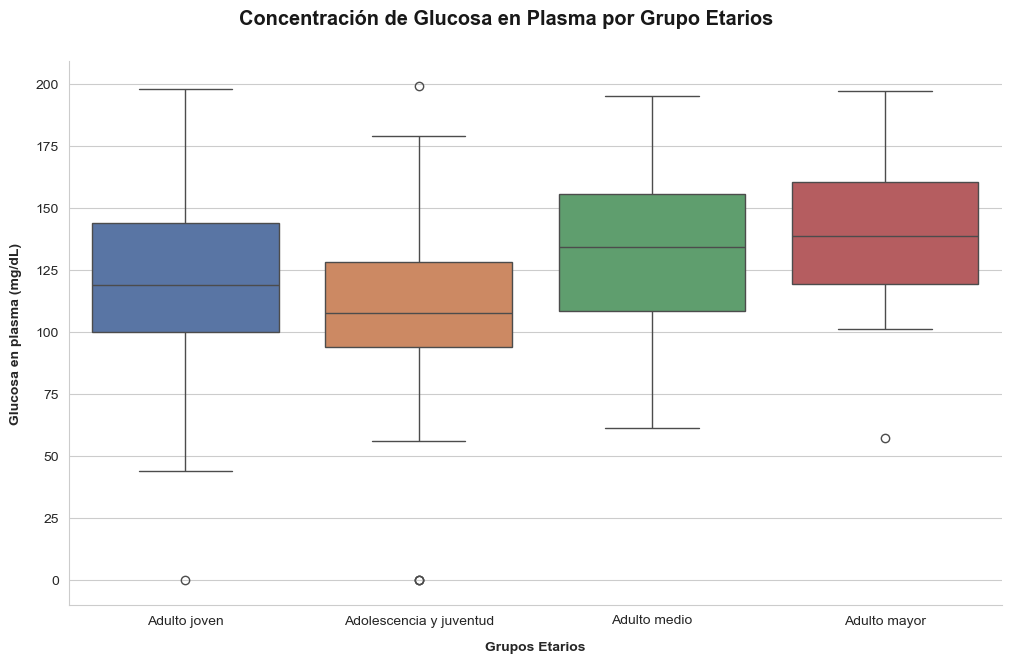

In [28]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Concentración de Glucosa en Plasma por Grupo Etarios",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.boxplot(data=df_train[["plas", "class", "age_category"]],
			y="plas",
			x="age_category",
			hue="age_category",
			palette="deep",
			ax=ax)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("Grupos Etarios", labelpad=10, fontdict=font_config)
ax.set_ylabel("Glucosa en plasma (mg/dL)",
			  labelpad=10,
			  fontdict=font_config)
sns.despine(ax=ax)
plt.show()

##### Análisis de `MASS`

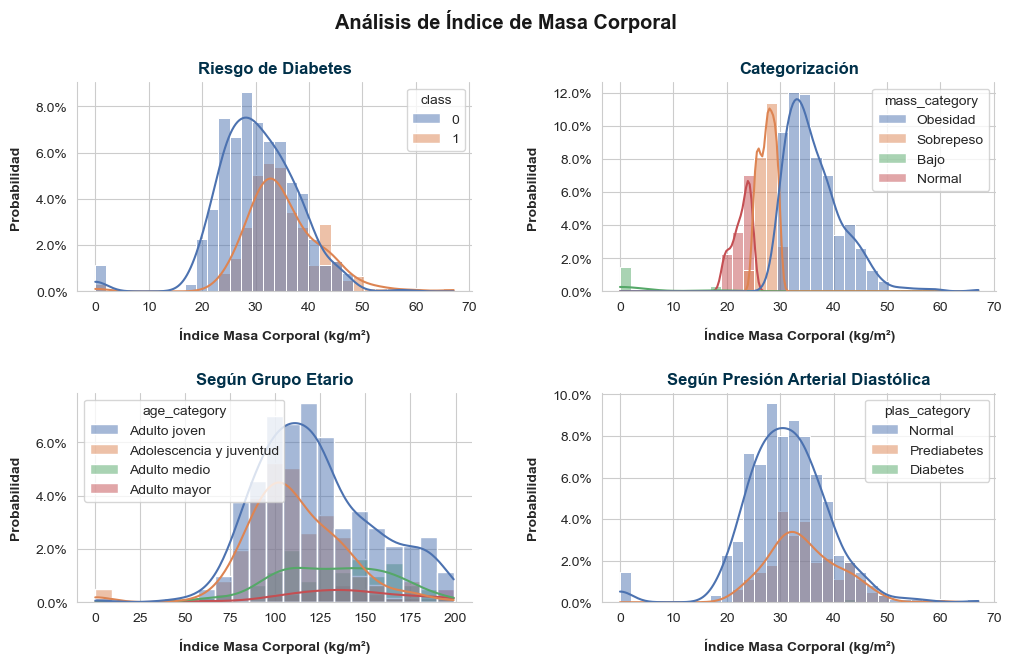

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Análisis de Índice de Masa Corporal",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Riesgo de Diabetes",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["class", "mass"]],
			 x="mass",
			 hue="class",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("Índice Masa Corporal (kg/m²)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Categorización",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["mass_category", "mass"]],
			 x="mass",
			 hue="mass_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][1])
sns.despine(ax=axs[0][1])
axs[0][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("Índice Masa Corporal (kg/m²)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Según Grupo Etario",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["age_category", "plas"]],
			 x="plas",
			 hue="age_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][0])
sns.despine(ax=axs[1][0])
axs[1][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("Índice Masa Corporal (kg/m²)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Según Presión Arterial Diastólica",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["plas_category", "mass"]],
			 x="mass",
			 hue="plas_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][1])
sns.despine(ax=axs[1][1])
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("Índice Masa Corporal (kg/m²)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

##### Análisis de `SKIN`

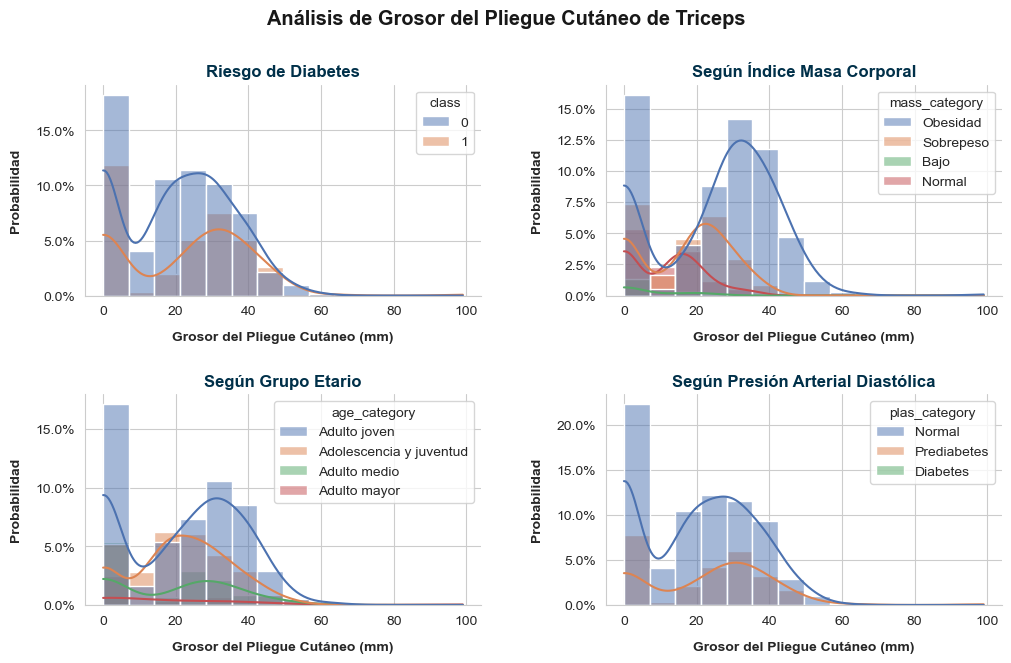

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Análisis de Grosor del Pliegue Cutáneo de Triceps",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Riesgo de Diabetes",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["class", "skin"]],
			 x="skin",
			 hue="class",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("Grosor del Pliegue Cutáneo (mm)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Según Índice Masa Corporal",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["mass_category", "skin"]],
			 x="skin",
			 hue="mass_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[0][1])
sns.despine(ax=axs[0][1])
axs[0][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("Grosor del Pliegue Cutáneo (mm)",
					 labelpad=10,
					 fontdict=font_config)
axs[0][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Según Grupo Etario",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["age_category", "skin"]],
			 x="skin",
			 hue="age_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][0])
sns.despine(ax=axs[1][0])
axs[1][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("Grosor del Pliegue Cutáneo (mm)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Según Presión Arterial Diastólica",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train[["plas_category", "skin"]],
			 x="skin",
			 hue="plas_category",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 palette="deep",
			 ax=axs[1][1])
sns.despine(ax=axs[1][1])
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("Grosor del Pliegue Cutáneo (mm)",
					 labelpad=10,
					 fontdict=font_config)
axs[1][1].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

##### Análisis de `TEST` y `PEDI`

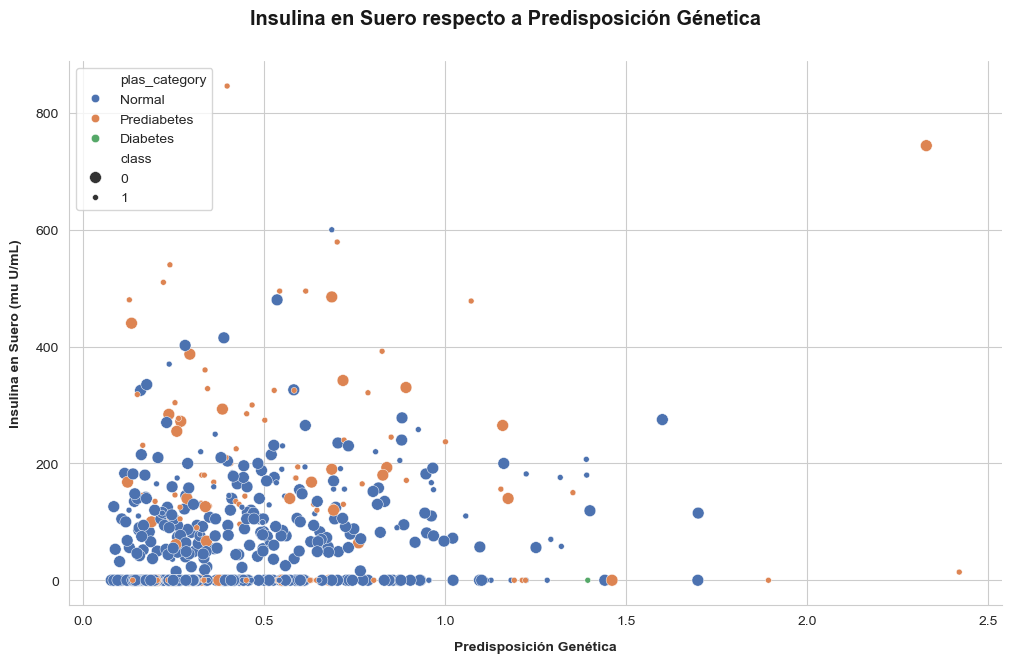

In [31]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Insulina en Suero respecto a Predisposición Génetica",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.scatterplot(y="test",
				x="pedi",
				hue="plas_category",
				size="class",
				palette="deep",
				legend="auto",
				data=df_train)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("Predisposición Genética", labelpad=10, fontdict=font_config)
ax.set_ylabel("Insulina en Suero (mu U/mL)",
			  labelpad=10,
			  fontdict=font_config)
sns.despine(ax=ax)
plt.show()

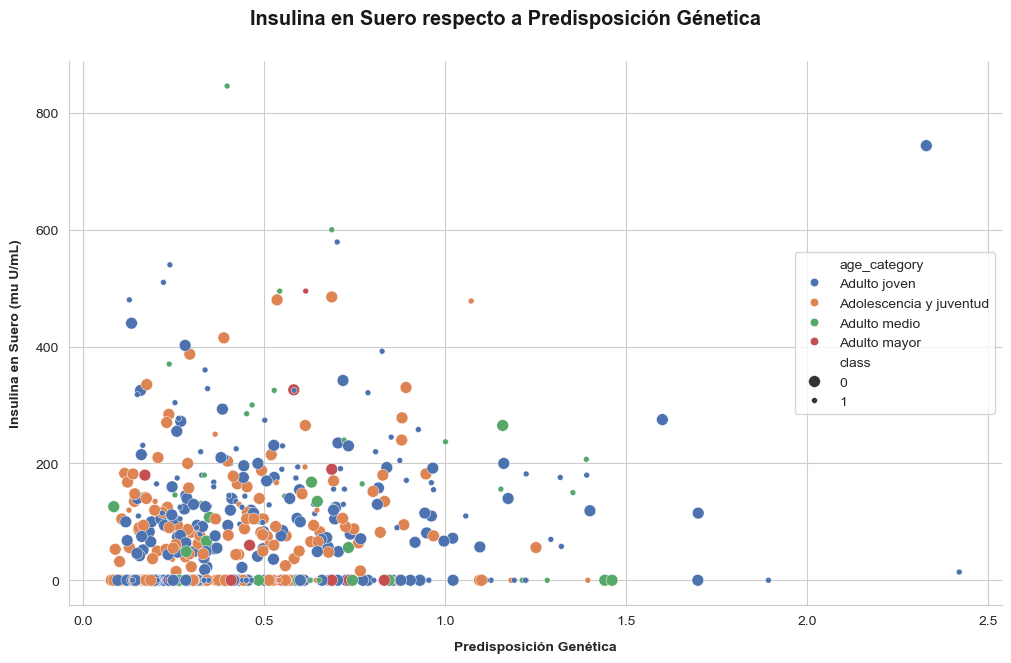

In [32]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Insulina en Suero respecto a Predisposición Génetica",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.scatterplot(y="test",
				x="pedi",
				hue="age_category",
				size="class",
				palette="deep",
				legend="auto",
				data=df_train)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("Predisposición Genética", labelpad=10, fontdict=font_config)
ax.set_ylabel("Insulina en Suero (mu U/mL)",
			  labelpad=10,
			  fontdict=font_config)
sns.despine(ax=ax)
plt.show()

#### `Correlación Spearman`

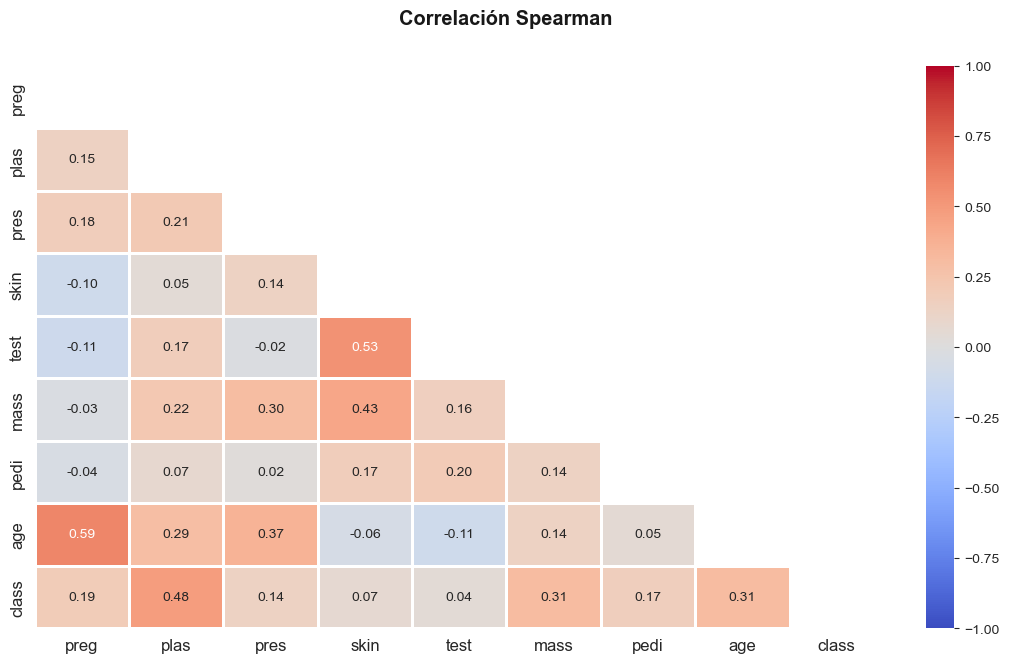

In [33]:
correlations = df_train.iloc[:, :9].corr("spearman")
mask = np.triu(np.ones_like(correlations, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Correlación Spearman",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.heatmap(data=correlations,
			mask=mask,
			annot=True,
			cmap="coolwarm",
			fmt=".2f",
			center=0,
			linewidths=1,
			vmax=1,
			vmin=-1,
			ax=ax)
ax.set_xticks(ax.get_xticks(), labels=correlations.columns, fontsize=12)
ax.set_yticks(ax.get_yticks(), labels=correlations.columns, fontsize=12)
ax.grid(False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
sns.despine(left=True, bottom=True, ax=ax)
plt.show()

No existe colinealidad entre las variables. En principio, nuestro target tiene buena correlación en general con todas las `features` de nuestro dataset.

## Machine Learning
### Baseline: `LogisticRegression`

In [34]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

#### Escalado

In [35]:
from sklearn.preprocessing import OneHotEncoder, \
								  OrdinalEncoder, \
								  StandardScaler

**TRAIN**

In [36]:
to_scale = ["plas", "pres", "skin", "test", "mass", "pedi"]

In [37]:
standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")

transformed = standard_scaler.fit_transform(df_train_scaled.loc[:, to_scale])

df_train_scaled = df_train_scaled.drop(columns=to_scale).join(transformed)
df_train_scaled.sample(2)

,preg,age,class,age_category,plas_category,pres_category,mass_category,plas,pres,skin,test,mass,pedi
194,4,27,0,Adulto joven,Prediabetes,Alta,Sobrepeso,0.788411,0.822195,0.402959,0.192893,-0.388779,-0.874181
248,1,28,0,Adulto joven,Normal,Normal,Obesidad,0.003528,0.476254,1.150630,-0.035579,0.894814,-0.649087


**TEST**

In [38]:
standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")

transformed = standard_scaler.fit_transform(df_test_scaled.loc[:, to_scale])

df_test_scaled = df_test_scaled.drop(columns=to_scale).join(transformed)
df_test_scaled.sample(2)

,preg,age,class,age_category,plas_category,pres_category,mass_category,plas,pres,skin,test,mass,pedi
102,12,38,1,Adulto joven,Prediabetes,Normal,Obesidad,0.929851,-0.138421,1.254415,1.53235,1.221575,0.690664
105,2,21,0,Adolescencia y juventud,Normal,Normal,Obesidad,-0.275824,0.196749,0.738409,-0.72183,0.451305,-0.904770


#### Encoding

In [39]:
pres_encoding = ["Alta", "Normal", "Baja"]
mass_encoding = ["Obesidad", "Sobrepeso", "Normal", "Bajo"]
plas_encoding = ["Diabetes", "Prediabetes", "Normal"]

**TRAIN**

In [40]:
to_encode = [pres_encoding, mass_encoding, plas_encoding]
preprocessing = OrdinalEncoder(categories=to_encode)
preprocessing.set_output(transform="pandas")

columns = ["pres_category", "mass_category", "plas_category"]
transformed = preprocessing.fit_transform(df_train_scaled[columns])

df_train_scaled = df_train_scaled.drop(columns=columns).join(transformed)
df_train_scaled.head()

,preg,age,class,age_category,plas,pres,skin,test,mass,pedi,pres_category,mass_category,plas_category
0,2,26,0,Adulto joven,-0.655773,-0.017949,0.278347,-0.061941,0.831270,-0.452129,1.0,0.0,2.0
1,0,33,1,Adulto joven,0.003528,-0.116790,0.589877,0.764073,0.297499,-0.830413,1.0,0.0,2.0
2,3,29,0,Adulto joven,-0.310425,1.069297,-0.531630,-0.000429,-0.452323,0.082470,0.0,1.0,2.0
3,7,24,0,Adolescencia y juventud,-0.498797,-3.378527,-1.279301,-0.685845,-4.061635,-0.511529,2.0,3.0,2.0
4,0,31,0,Adulto joven,-0.655773,0.970456,2.459054,0.280767,1.886104,1.542458,0.0,0.0,2.0


**TEST**

In [41]:
to_encode = [pres_encoding, mass_encoding, plas_encoding]
preprocessing = OrdinalEncoder(categories=to_encode)
preprocessing.set_output(transform="pandas")

columns = ["pres_category", "mass_category", "plas_category"]
transformed = preprocessing.fit_transform(df_test_scaled[columns])

df_test_scaled = df_test_scaled.drop(columns=columns).join(transformed)
df_test_scaled.sample(2)

,preg,age,class,age_category,plas,pres,skin,test,mass,pedi,pres_category,mass_category,plas_category
104,7,48,0,Adulto medio,-0.461312,1.336326,-0.164603,-0.72183,-1.190252,-0.671096,0.0,2.0,2.0
78,0,25,0,Adulto joven,-1.481498,-4.830797,-1.325617,-0.72183,-1.392290,-0.383702,2.0,2.0,2.0


#### `LogisticRegression`

In [93]:
best_features = ["preg", "age", "plas", "pres", "mass", "pedi"]
features = ["preg", "age", "plas", "pres", "skin", "test", "mass", "pedi"]
features_full = [
	"preg",
	"age",
	"plas",
	"pres",
	"skin",
	"test",
	"mass",
	"pedi",
	"pres_category",
	"mass_category",
	"plas_category"
]
target = "class"

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report


logistic_regression = LogisticRegression(max_iter=1000,
										 random_state=99)
logistic_regression.fit(df_train_scaled[best_features],
						df_train_scaled[target])

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",99
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

##### Feature Importance

In [97]:
intercept = logistic_regression.intercept_
print("Ordenada al origen:", intercept)

coeficientes = logistic_regression.coef_.ravel()
coeficientes = pd.Series(data=coeficientes,
						 index=df_train_scaled[best_features].columns,
						 name="coeficientes")
coef = pd.DataFrame(coeficientes, index=df_train_scaled[best_features].columns)
coef

Ordenada al origen: [-1.76144068]


,coeficientes
preg,0.120634
age,0.013194
plas,1.077630
pres,-0.267399
mass,0.682550
pedi,0.278292


Salvo `skin` y `age` las variables tienen incidencia en nuestro target, algunas en mayor medida que otras.

In [98]:
predicts = logistic_regression.predict(df_train_scaled[best_features])
print(classification_report(df_train_scaled[target], predicts))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       400
           1       0.73      0.58      0.65       214

    accuracy                           0.78       614
   macro avg       0.76      0.73      0.74       614
weighted avg       0.77      0.78      0.77       614



In [99]:
predicts = logistic_regression.predict(df_test_scaled[best_features])
print(classification_report(df_test_scaled[target], predicts))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       100
           1       0.70      0.57      0.63        54

    accuracy                           0.77       154
   macro avg       0.75      0.72      0.73       154
weighted avg       0.76      0.77      0.76       154



**TRAIN**

In [145]:
results = cross_validate(logistic_regression,
						 df_train_scaled[best_features],
						 df_train_scaled[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 72.864
TRAIN Recall: 57.478
-----------------------------------
TEST Balanced Accuracy: 71.103
TEST Recall: 54.707


**TEST**

In [147]:
results = cross_validate(logistic_regression,
						 df_test_scaled[best_features],
						 df_test_scaled[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 74.197
TRAIN Recall: 60.645
-----------------------------------
TEST Balanced Accuracy: 71.136
TEST Recall: 57.273


Nuestro modelo baseline tiene un pobre rendimiento en lo que respecta a nuestra métrica seleccionada `recall`. Si tomamos en cuenta `balanced_accuracy`, tiene un rendimiento aceptable aunque parece que tiene rango de mejora.

##### `GridSearchCV`

In [149]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = [
	# L1
	{
		"C": np.logspace(-3, 2, 20),
		"l1_ratio": [1.0],
		"solver": ["liblinear", "saga"],
		"max_iter": [1000, 2000, 5000]
	},
	# L2
	{
		"C": np.logspace(-3, 2, 20),
		"l1_ratio": [0.0],
		"solver": [
			"lbfgs",
			"liblinear",
			"newton-cg",
			"newton-cholesky",
			"sag",
			"saga"
		],
		"max_iter": [1000, 2000, 5000]
	},
	# ElasticNet
	{
		"C": np.logspace(-3, 2, 20),
		"l1_ratio": np.linspace(0.1, 0.9, 5),
		"solver": ["saga"],
		"max_iter": [1000, 2000, 5000]
	},
	# No regularización
	{
		"C": np.logspace(-3, 2, 20),
		"solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
		"max_iter": [1000, 2000, 5000]
	}
]

logistic_regression = LogisticRegression(random_state=99)
grid_search = GridSearchCV(logistic_regression,
						   param_grid,
						   n_jobs=-1,
						   scoring="balanced_accuracy",
						   cv=10)
grid_search.fit(df_train_scaled[best_features], df_train_scaled[target])

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=99)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'C': array([1.0000...00000000e+02]), 'l1_ratio': [1.0], 'max_iter': [1000, 2000, ...], 'solver': ['liblinear', 'saga']}, {'C': array([1.0000...00000000e+02]), 'l1_ratio': [0.0], 'max_iter': [1000, 2000, ...], 'solver': ['lbfgs', 'liblinear', ...]}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fol

In [150]:
grid_search.best_params_

{'C': np.float64(0.7847599703514607),
 'l1_ratio': 0.0,
 'max_iter': 1000,
 'solver': 'liblinear'}

In [151]:
logistic_regression = LogisticRegression(C=np.float64(0.7847599703514607),
										 l1_ratio=0.0,
										 max_iter=1000,
										 solver="liblinear",
										 random_state=99)
logistic_regression.fit(df_train_scaled[best_features],
						df_train_scaled[target])

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",np.float64(0.7847599703514607)
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",99
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of 

In [152]:
intercept = logistic_regression.intercept_
print("Ordenada al origen:", intercept)

coeficientes = logistic_regression.coef_.ravel()
coeficientes = pd.Series(data=coeficientes,
						 index=df_train_scaled[best_features].columns,
						 name="coeficientes")
coef = pd.DataFrame(coeficientes, index=df_train_scaled[best_features].columns)
coef

Ordenada al origen: [-1.55179756]


,coeficientes
preg,0.122052
age,0.007630
plas,1.080886
pres,-0.251165
mass,0.663301
pedi,0.276124


In [153]:
results = cross_validate(logistic_regression,
						 df_train_scaled[best_features],
						 df_train_scaled[target],
						 cv=10,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 73.076
TRAIN Recall: 57.736
-----------------------------------
TEST Balanced Accuracy: 71.939
TEST Recall: 55.628


In [154]:
results = cross_validate(logistic_regression,
						 df_test_scaled[best_features],
						 df_test_scaled[target],
						 cv=10,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 74.100
TRAIN Recall: 60.089
-----------------------------------
TEST Balanced Accuracy: 72.167
TEST Recall: 59.333


### Bagging
#### `RandomForestClassifier`

In [155]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(n_estimators=200,
									   max_depth=7,
									   class_weight="balanced",
									   n_jobs=-1,
									   random_state=99)
random_forest.fit(df_train[best_features], df_train[target])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",7
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [156]:
random_forest.feature_importances_

coeficientes = random_forest.feature_importances_
coeficientes = pd.Series(data=coeficientes,
						 index=df_train[best_features].columns,
						 name="coeficientes")
coef = pd.DataFrame(coeficientes, index=df_train[best_features].columns)
coef

,coeficientes
preg,0.083261
age,0.160777
plas,0.354472
pres,0.079655
mass,0.203949
pedi,0.117886


**TRAIN**

In [157]:
predicts = random_forest.predict(df_train[best_features])
print(classification_report(df_train[target], predicts))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       400
           1       0.86      0.96      0.91       214

    accuracy                           0.93       614
   macro avg       0.92      0.94      0.93       614
weighted avg       0.94      0.93      0.93       614



In [158]:
results = cross_validate(random_forest,
						 df_train[best_features],
						 df_train[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 94.693
TRAIN Recall: 96.261
-----------------------------------
TEST Balanced Accuracy: 73.262
TEST Recall: 67.774


**TEST**

In [114]:
predicts = random_forest.predict(df_test[best_features])
print(classification_report(df_test[target], predicts))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.64      0.70      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



In [159]:
results = cross_validate(random_forest,
						 df_test[best_features],
						 df_test[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")


TRAIN Balanced Accuracy: 100.000
TRAIN Recall: 100.000
-----------------------------------
TEST Balanced Accuracy: 68.545
TEST Recall: 57.091


En esta primer impresión podemos notar como nuestro modelo se encuentra sobreajustado a los datos de entrenamiento.

##### `RandomizedSearchCV`

In [160]:
from sklearn.metrics import make_scorer, recall_score

In [163]:
param_dist = {
	"n_estimators": [100, 200, 500, 800, 1000],
	"bootstrap": [True, False],
	"criterion": ["gini", "entropy", "log_loss"],
	"max_depth": [None, 5, 10, 20, 30],
	"max_features": ["sqrt", "log2", None],
	"min_samples_leaf": [1, 2, 4, 6, 10],
	"min_samples_split": [2, 6, 8, 10],
}

random_forest = RandomForestClassifier(class_weight="balanced",
									   n_jobs=-1,
									   random_state=99)
random_search = RandomizedSearchCV(estimator=random_forest,
								   param_distributions=param_dist,
								   n_iter=50,
								   scoring="balanced_accuracy",
								   cv=5,
								   verbose=2,
								   random_state=42,
								   n_jobs=-1)
random_search.fit(df_train[best_features], df_train[target])

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END bootstrap=True, criterion=gini, max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=500; total time=   1.7s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=2, n_estimators=300; total time=   0.9s
[CV] END bootstrap=False, criterion=gini, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   2.7s
[CV] END bootstrap=True, criterion=gini, max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=entropy, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END boo

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=99)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'bootstrap': [True, False], 'criterion': ['gini', 'entropy', ...], 'max_depth': [None, 5, ...], 'max_features': ['sqrt', 'log2', ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies tha

In [164]:
random_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 5,
 'criterion': 'log_loss',
 'bootstrap': True}

In [165]:
random_forest = RandomForestClassifier(n_estimators=100,
									   bootstrap=True,
									   class_weight="balanced",
									   criterion="log_loss",
									   max_depth=5,
									   min_samples_split=6,
									   min_samples_leaf=10,
									   max_features="sqrt",
									   n_jobs=-1,
									   random_state=99)
random_forest.fit(df_train[best_features], df_train[target])

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'log_loss'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",6
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",10
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metr

**TRAIN**

In [170]:
predicts = random_forest.predict(df_train[best_features])
print(classification_report(df_train[target], predicts))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85       400
           1       0.69      0.86      0.76       214

    accuracy                           0.81       614
   macro avg       0.80      0.82      0.81       614
weighted avg       0.83      0.81      0.82       614



In [171]:
results = cross_validate(random_forest,
						 df_train[best_features],
						 df_train[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 83.401
TRAIN Recall: 85.864
-----------------------------------
TEST Balanced Accuracy: 76.418
TEST Recall: 77.586


**TEST**

In [172]:
predicts = random_forest.predict(df_test[best_features])
print(classification_report(df_test[target], predicts))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82       100
           1       0.65      0.80      0.72        54

    accuracy                           0.78       154
   macro avg       0.76      0.78      0.77       154
weighted avg       0.80      0.78      0.78       154



In [178]:
results = cross_validate(random_forest,
						 df_test[best_features],
						 df_test[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 83.897
TRAIN Recall: 83.795
-----------------------------------
TEST Balanced Accuracy: 73.591
TEST Recall: 72.182


### Boosting
#### XGBoost

In [129]:
from xgboost import XGBClassifier


xgboost = XGBClassifier(objective="binary:logistic",
						eval_metric="logloss",
						n_jobs=-1,
						random_state=99)
xgboost.fit(df_train[best_features], df_train[target])

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

**TRAIN**

In [130]:
predicts = xgboost.predict(df_train[best_features])
print(classification_report(df_train[target], predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       214

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



In [179]:
results = cross_validate(xgboost,
						 df_train[best_features],
						 df_train[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 89.274
TRAIN Recall: 84.111
-----------------------------------
TEST Balanced Accuracy: 74.163
TEST Recall: 63.577


**TEST**

In [180]:
predicts = xgboost.predict(df_test[best_features])
print(classification_report(df_test[target], predicts))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.63      0.63      0.63        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



In [181]:
results = cross_validate(xgboost,
						 df_test[best_features],
						 df_test[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 84.300
TRAIN Recall: 76.850
-----------------------------------
TEST Balanced Accuracy: 67.318
TEST Recall: 51.636


##### `RandomizedSearchCV`

In [186]:
param_dist = {
	"n_estimators": [100, 300, 500, 800],
	"max_depth": [3, 5, 7, 10],
	"learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
	"subsample": [0.6, 0.8, 1.0],
	"colsample_bytree": [0.6, 0.8, 1.0],
	"gamma": [0, 0.1, 0.3, 0.5],
	"min_child_weight": [1, 3, 5],
	"reg_alpha": [0, 0.01, 0.1, 1],
	"reg_lambda": [1, 1.5, 2, 5]
}

xgboost = XGBClassifier(objective="binary:logistic",
						eval_metric="logloss",
						n_jobs=-1,
						random_state=99)
random_search = RandomizedSearchCV(estimator=xgboost,
								   param_distributions=param_dist,
								   n_iter=80,
								   scoring="balanced_accuracy",
								   cv=5,
								   n_jobs=-1,
								   verbose=2,
								   random_state=42)
random_search.fit(df_train[best_features], df_train[target])

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=7, min_child_weight=5, n_estimators=800, reg_alpha=0.1, reg_lambda=5, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=800, reg_alpha=0.01, reg_lambda=5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.5, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=800, reg_alpha=0.01, reg_lambda=5, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, max_depth=5, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=2, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.02, 

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.005, 0.01, ...], 'max_depth': [3, 5, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",80
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'balanced_accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be 

In [187]:
random_search.best_params_

{'subsample': 1.0,
 'reg_lambda': 5,
 'reg_alpha': 0.1,
 'n_estimators': 800,
 'min_child_weight': 5,
 'max_depth': 7,
 'learning_rate': 0.05,
 'gamma': 0.3,
 'colsample_bytree': 1.0}

In [188]:
xgboost = XGBClassifier(objective="binary:logistic",
						subsample=1.0,
						reg_lambda=5,
						reg_alpha=0.1,
						n_estimators=800,
						min_child_weight=5,
						max_depth=7,
						learning_rate=0.05,
						gamma=.3,
						colsample_bytree=1.0,
						eval_metric="logloss",
						n_jobs=-1,
						random_state=99)
xgboost.fit(df_train[best_features], df_train[target])

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,1.0
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

**TRAIN**

In [189]:
predicts = xgboost.predict(df_train[best_features])
print(classification_report(df_train[target], predicts))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       400
           1       0.89      0.85      0.87       214

    accuracy                           0.91       614
   macro avg       0.90      0.89      0.90       614
weighted avg       0.91      0.91      0.91       614



In [190]:
results = cross_validate(xgboost,
						 df_train[best_features],
						 df_train[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 89.274
TRAIN Recall: 84.111
-----------------------------------
TEST Balanced Accuracy: 74.163
TEST Recall: 63.577


**TEST**

In [191]:
predicts = xgboost.predict(df_test[best_features])
print(classification_report(df_test[target], predicts))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       100
           1       0.63      0.63      0.63        54

    accuracy                           0.74       154
   macro avg       0.71      0.71      0.71       154
weighted avg       0.74      0.74      0.74       154



In [192]:
results = cross_validate(xgboost,
						 df_test[best_features],
						 df_test[target],
						 cv=5,
						 return_train_score=True,
						 scoring=["balanced_accuracy", "recall"],
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_balanced_accuracy"] * 100):.3f}")
print(f"TRAIN Recall: {np.mean(results["train_recall"] * 100):.3f}")
print("-"*35)
print(f"TEST Balanced Accuracy: {np.mean(results["test_balanced_accuracy"] * 100):.3f}")
print(f"TEST Recall: {np.mean(results["test_recall"] * 100):.3f}")

TRAIN Balanced Accuracy: 84.300
TRAIN Recall: 76.850
-----------------------------------
TEST Balanced Accuracy: 67.318
TEST Recall: 51.636

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=300, reg_alpha=0.01, reg_lambda=1.5, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=800, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=800, reg_alpha=0.01, reg_lambda=2, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=800, reg_alpha=1, reg_lambda=1, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, min_child_weight=1, n_estimators=800, reg_alpha=1, reg_lambda=1, subsample=0.6; total t

## Conclusión

Todos los modelos están sobreajustados al set de entrenamiento y no logran generalizar correctamente. Si tuviese que elegir un modelo sería el `RandomForest` ya que es el que logra ser más consistente entre los datos de entrenamiento y los de prueba... aunque el modelo tenga una performance que nos invita a realizar un mejor ajuste de los hiperparámetros en lo que respecta a la métrica seleccionada.